In [1]:
import random
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical
from torch.utils.data import DataLoader
from transformers.optimization import (
    AdamW,
    get_constant_schedule_with_warmup,
    get_cosine_with_min_lr_schedule_with_warmup,
)
from IPython.display import clear_output

In [2]:
SEED = 0
BATCH_SIZE = 256
LR = 0.002 * BATCH_SIZE / 1024
EPOCHS = 20
WARMUP_EPOCHS = 5
CLIP = 0.2
TARGET_KL = 0.015
GAMMA = 0.999
LAMBDA = 0.98
ENT_COEF = 0
V_COEF = 10
GRAD_NORM = False
OBS_NORM = False
NUM_ROLLOUT = 4
# set device
use_cuda = torch.cuda.is_available()
print("cuda:", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

cuda: False


In [3]:
class ActorCriticNet(nn.Module):
    def __init__(self, obs_space, action_space, use_obs_norm=True):
        super().__init__()
        h = 64
        self.use_obs_norm = use_obs_norm
        self.obs_space = obs_space
        self.obs_norms = nn.ModuleList([nn.BatchNorm1d(1, momentum=None, affine=False) for _ in range(obs_space)])
        self.pol = nn.Sequential(
            nn.Linear(obs_space, h, bias=True),
            nn.Tanh(),
            nn.Linear(h, action_space, bias=True),
        )
        self.val = nn.Sequential(
            nn.Linear(obs_space, h, bias=True),
            nn.Tanh(),
            nn.Linear(h, 1, bias=True),
        )
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        if self.use_obs_norm:
            norm_x = []
            for norm, obs in zip(self.obs_norms, x.chunk(chunks=self.obs_space, dim=1)):
                norm_x.append(norm(obs))
            x = torch.concat(norm_x, dim=1)
        logit = self.pol(x).reshape(x.shape[0], -1)
        log_p = self.log_softmax(logit)
        v = self.val(x).reshape(x.shape[0], 1)

        return log_p, v

In [4]:
losses = []
mean_losses = []


def learn(net, old_net, optimizer, scheduler, train_memory):
    global CLIP
    net.train()
    old_net.eval()
    all_advs = torch.tensor([adv for _, _, _, adv in train_memory]).to(device)

    for epoch in range(EPOCHS):
        dataloader = DataLoader(train_memory, shuffle=True, batch_size=BATCH_SIZE, pin_memory=use_cuda)
        for s, a, ret, adv in dataloader:
            s_batch = s.to(device).float()
            a_batch = a.to(device).long()
            ret_batch = ret.to(device).float()
            adv_batch = adv.to(device).float()
            adv_batch = (adv_batch - all_advs.mean()) / (all_advs.std() + 1e-8)
            batch_size = s_batch.shape[0]
            with torch.no_grad():
                log_p_batch_old, _ = old_net(s_batch)
                log_p_acting_old = log_p_batch_old[range(batch_size), a_batch]

            log_p_batch, v_batch = net(s_batch)
            log_p_acting = log_p_batch[range(batch_size), a_batch]
            p_ratio = (log_p_acting - log_p_acting_old).exp()
            p_ratio_clip = torch.clamp(p_ratio, 1 - CLIP, 1 + CLIP)
            p_loss_clip = torch.min(p_ratio * adv_batch, p_ratio_clip * adv_batch).mean()
            entropy = -(log_p_batch.exp() * log_p_batch).sum(dim=1).mean()
            p_loss = p_loss_clip + ENT_COEF * entropy

            v_loss = 0.5 * (ret_batch - v_batch).pow(2).mean()

            # approx_kl를 계산하되, 그래프에 포함되지 않도록 함
            with torch.no_grad():
                approx_kl = (log_p_batch_old - log_p_batch).mean().item()

            # approx_kl가 임계치를 초과하면 p_loss의 gradient 전파를 차단
            if approx_kl > TARGET_KL:
                p_loss_update = p_loss.detach()
            else:
                p_loss_update = p_loss

            # 최종 loss 구성
            loss = -(p_loss_update - V_COEF * v_loss)

            # optimizer 업데이트
            optimizer.zero_grad()
            loss.backward()

            losses.append(loss.item())
            mean_losses.append(np.mean(losses[-200:]))

            if GRAD_NORM:
                nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.5)
            optimizer.step()
            scheduler.step()
    train_memory.clear()


def get_action_and_value(obs, old_net):
    old_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p, v = old_net(state)
        m = Categorical(log_p.exp())
        action = m.sample()

    return action.item(), v.item()


def _compute_adv_with_gae(rewards, values, roll_memory):
    rew = np.array(rewards, "float")
    val = np.array(values[:-1], "float")
    _val = np.array(values[1:], "float")
    delta = rew + GAMMA * _val - val
    dis_r = np.array([GAMMA ** (i) * r for i, r in enumerate(rewards)], "float")
    gae_dt = np.array([(GAMMA * LAMBDA) ** (i) * dt for i, dt in enumerate(delta.tolist())], "float")
    for i, data in enumerate(roll_memory):
        data.append(sum(dis_r[i:] / GAMMA ** (i)))
        data.append(sum(gae_dt[i:] / (GAMMA * LAMBDA) ** (i)))

    rewards.clear()
    values.clear()

    return roll_memory


def compute_adv_with_gae(rewards, values, roll_memory):
    """
    Generalized Advantage Estimation (GAE)와 return을 계산하여 roll_memory에 추가합니다.

    Parameters:
        rewards     : 각 timestep의 보상을 담은 리스트 (길이 T)
        values      : 상태가치를 담은 리스트 (길이 T+1, 마지막 값은 bootstrap value)
        roll_memory : rollout 데이터 리스트 (각 항목은 추후 return과 advantage를 추가할 리스트)

    Returns:
        roll_memory : 각 transition에 return과 advantage가 추가된 rollout 데이터
    """
    rollout_length = len(rewards)
    advantages = np.zeros(rollout_length, dtype=np.float32)
    gae = 0.0

    # 역방향 순회로 advantage를 누적 계산 (A_t = δ_t + γλ A_{t+1})
    for step in reversed(range(rollout_length)):
        # δ_t = r_t + γ * V(s_{t+1}) - V(s_t)
        delta = rewards[step] + GAMMA * values[step + 1] - values[step]
        gae = delta + GAMMA * LAMBDA * gae
        advantages[step] = gae

    # Return = Advantage + V(s_t)
    returns = advantages + np.array(values[:-1], dtype=np.float32)

    # 각 rollout 데이터에 계산된 return과 advantage를 추가 (순서: return, advantage)
    for idx, data in enumerate(roll_memory):
        data.append(returns[idx])
        data.append(advantages[idx])

    # rollout이 끝난 후, 리스트를 클리어하여 다음 rollout 준비
    rewards.clear()
    values.clear()

    return roll_memory

## Main

In [5]:
# make an environment
# env = gym.make("CartPole-v0")
env = gym.make("CartPole-v1")
# env = gym.make("MountainCar-v0")
# env = gym.make("LunarLander-v2")

obs_space = env.observation_space.shape[0]
action_space = env.action_space.n
print(obs_space)
print(action_space)
print(env.spec.reward_threshold)
print(env.spec.max_episode_steps)

4
2
475.0
500


In [6]:
# hyperparameter
n_episodes = 100000
max_ep_len = 1000
total_epochs = env.spec.max_episode_steps * NUM_ROLLOUT // BATCH_SIZE
n_eval = 10

# global values
steps = 0
ep_rewards = []
reward_eval = []

# make memories
train_memory = []
roll_memory = []
rewards = []
values = []


def plot():
    clear_output(True)
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(ep_rewards, alpha=0.5)
    plt.subplot(121)
    plt.plot(reward_eval)
    plt.title(f"Reward: " f"{reward_eval[-1]}")
    plt.subplot(122)
    plt.plot(losses, alpha=0.5)
    plt.subplot(122)
    plt.plot(mean_losses)
    plt.title(f"Loss: " f"{np.mean(list(reversed(losses))[: n_eval]):.4f}")
    plt.show()

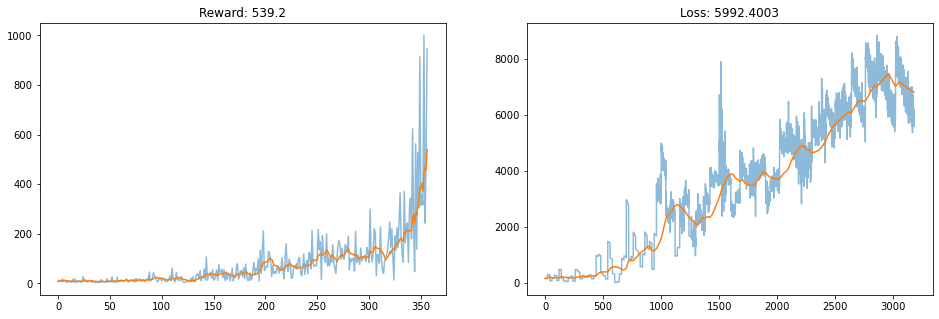


CartPole-v1 is sloved! 357 Episode in 28114 steps


In [7]:
# make nerual networks
net = ActorCriticNet(obs_space, action_space, OBS_NORM).to(device)
old_net = deepcopy(net)
no_decay = ["bias"]
grouped_parameters = [
    {"params": [p for n, p in net.named_parameters() if not any(nd in n for nd in no_decay)], "weight_decay": 0.01},
    {"params": [p for n, p in net.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
]
# optimizer = torch.optim.AdamW(net.parameters(), lr=LR, eps=1e-6)
optimizer = torch.optim.AdamW(grouped_parameters, lr=LR, eps=1e-8)
# optimizer = AdamW(grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=total_epochs * EPOCHS * WARMUP_EPOCHS)
# scheduler = get_cosine_with_min_lr_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=total_epochs * EPOCHS * WARMUP_EPOCHS,
#     num_training_steps=total_epochs * EPOCHS * 2000,
#     min_lr_rate=0.1,
# )

# play!
solved = False
for i in range(1, n_episodes + 1):
    obs, _ = env.reset()
    done = False
    timeout = False
    ep_reward = 0
    ep_steps = 0
    while not done:
        # env.render()
        action, value = get_action_and_value(obs, old_net)
        out = env.step(action)
        _obs, reward, done, _, _ = env.step(action)

        # store
        roll_memory.append([obs, action])
        rewards.append(reward)
        values.append(value)

        obs = _obs
        steps += 1
        ep_steps += 1
        ep_reward += reward

        timeout = ep_steps >= max_ep_len

        if done or timeout:
            if done:
                _value = 0.0
            else:
                _, _value = get_action_and_value(_obs, old_net)

            values.append(_value)
            train_memory.extend(compute_adv_with_gae(rewards, values, roll_memory))
            roll_memory.clear()

            ep_rewards.append(ep_reward)
            reward_eval.append(np.mean(list(reversed(ep_rewards))[:n_eval]).round(decimals=2))
            plot()
            if timeout:
                break
            if len(ep_rewards) >= n_eval:
                if reward_eval[-1] >= env.spec.reward_threshold:
                    # if reward_eval[-1] >= 495:
                    print("\n{} is sloved! {:3} Episode in {:3} steps".format(env.spec.id, i, steps))
                    torch.save(net.state_dict(), f"./test/saved_models/{env.spec.id}_ep{i}_clear_model_ppo_st.pt")
                    solved = True
                    break
    if solved:
        break
    if i % NUM_ROLLOUT == 0:
        learn(net, old_net, optimizer, scheduler, train_memory)
        old_net.load_state_dict(net.state_dict())

env.close()

In [8]:
[("CartPole-v0", 186, 3, 4), ("CartPole-v1", 277, 3, 4), ("MountainCar-v0", None), ("LunarLander-v2", None)]

[('CartPole-v0', 186, 3, 4),
 ('CartPole-v1', 277, 3, 4),
 ('MountainCar-v0', None),
 ('LunarLander-v2', None)]